In [1]:
import pickle as pkl
from scipy.special import softmax
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm import tqdm

from vla_calibration.utils import *
from vla_calibration.calibration import *

plt.style.use('seaborn-v0_8')
pal = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [2]:
all_prompt_probs = {}
all_base_data = {}

In [3]:
def run_experiment(
        task_name, 
        quant=None,
        alternate_set=1, 
        n_prompts=20, 
        n_cal_bins=12,
):
    
    data_save_dir = f"/local/zemel/tom/code/vla_uq/results/libero_{task_name}"
    if quant is not None:
        data_save_dir += f"/{quant}"

    top_n_steps=1

    if task_name not in all_base_data:
        all_base_data[task_name] = dict()
        base_probs, _, correct = get_base_data(data_save_dir, top_n_steps)
        all_base_data[task_name]["base_probs"] = base_probs
        all_base_data[task_name]["correct"] = correct
    else:
        base_probs = all_base_data[task_name]["base_probs"]
        correct = all_base_data[task_name]["correct"]

    base_probs = np.expand_dims(base_probs, axis=2)

    all_probs = []

    if n_prompts < 20:
        prompt_list = list(np.arange(20))
        random.shuffle(prompt_list)
        prompt_list = prompt_list[:n_prompts]
    else:
        prompt_list = range(n_prompts)

    if task_name not in all_prompt_probs:
        all_prompt_probs[task_name] = dict()

    for i in prompt_list:

        if i in all_prompt_probs[task_name]:
            prompt_probs = all_prompt_probs[task_name][i]
        else:

            prompt_probs = []

            if alternate_set == 1:
                data_save_str = f"{data_save_dir}/episode_data_prompt_{i}.pkl"
            elif alternate_set == 2:
                data_save_str = f"{data_save_dir}/episode_data_prompt_{i}_v2.pkl"
            elif alternate_set == 3:
                data_save_str = f"{data_save_dir}/episode_data_prompt_{i}_v3.pkl"
            else:
                raise ValueError

            with open(data_save_str, "rb") as f:  # "rb" = read binary mode
                data = pkl.load(f)

            for episode in data:

                episode_probs = []

                steps = episode["steps"]

                for step in steps[:top_n_steps]:

                    logits = step["logits"]
                    probs = softmax(logits, -1)

                    episode_probs.append(probs)

                episode_probs = np.stack(episode_probs)
                prompt_probs.append(episode_probs)

            prompt_probs = np.stack(prompt_probs)
            all_prompt_probs[task_name][i] = prompt_probs

        all_probs.append(prompt_probs)

    
    all_probs = np.stack(all_probs)
    ens_probs = np.transpose(all_probs, (1,2,0,3,4))

    base_probs = base_probs[:,0]
    ens_probs = ens_probs[:,0]

    base_probs = np.max(base_probs, -1)
    ens_probs = np.max(ens_probs, -1)

    base_conf = np.mean(base_probs, -2)
    ens_conf = np.mean(ens_probs, -2)


    mean_base_conf = np.mean(base_conf, -1)
    mean_ens_conf = np.mean(ens_conf, -1)

    base_ece1 = round(get_ece(mean_base_conf, correct, n_cal_bins, p=1), 3)
    ens_ece1 = round(get_ece(mean_ens_conf, correct, n_cal_bins, p=1), 3)

    base_ece2 = round(get_ece(mean_base_conf, correct, n_cal_bins, p=2), 3)
    ens_ece2 = round(get_ece(mean_ens_conf, correct, n_cal_bins, p=2), 3)

    base_brier = round(np.mean((mean_base_conf - correct)**2), 3)
    ens_brier = round(np.mean((mean_ens_conf - correct)**2), 3)

    base_ce = cross_entropy(correct, mean_base_conf)
    ens_ce = cross_entropy(correct, mean_ens_conf)

    if quant is not None:
        quant_tag = quant
    else:
        quant_tag = "Full"

    base_row = [task_name, quant_tag, "baseline", base_ece1, base_ece2, base_brier, base_ce, np.mean(correct)]
    ens_row = [task_name, quant_tag, "reprompt", ens_ece1, ens_ece2, ens_brier, ens_ce, np.mean(correct)]
    rows = [base_row, ens_row]
    
    df = pd.DataFrame(rows, columns=["Dataset","Model","Method","ECE-1","ECE-2","Brier","NLL","Accuracy"])
    return df
    


In [4]:
n_bins = 12
alternate_set = 1

full_df = pd.DataFrame()

In [5]:
n_prompt_list = [1,5,10,20]

n_trials = 1000

random.seed(0)
np.random.seed(0)

for n_prompts in n_prompt_list:

    print(n_prompts)

    if n_prompts == 20:
        r = 1
    else:
        r = n_trials

    for j in tqdm(range(r)):

        df = run_experiment(
            "spatial", 
            alternate_set=alternate_set, 
            n_cal_bins=n_bins,
            n_prompts=n_prompts
        )
        df["n_prompts"] = n_prompts
        full_df = pd.concat([full_df, df])

        # display(full_df)

        df = run_experiment(
            "object", 
            alternate_set=alternate_set, 
            n_cal_bins=n_bins,
            n_prompts=n_prompts
        )
        df["n_prompts"] = n_prompts
        full_df = pd.concat([full_df, df])

        # display(full_df)

        df = run_experiment(
            "goal", 
            alternate_set=alternate_set,  
            n_cal_bins=n_bins,
            n_prompts=n_prompts
        )
        df["n_prompts"] = n_prompts
        full_df = pd.concat([full_df, df])

        # display(full_df)

1


100%|██████████| 1000/1000 [00:54<00:00, 18.41it/s]


5


100%|██████████| 1000/1000 [00:19<00:00, 50.94it/s]


10


100%|██████████| 1000/1000 [00:35<00:00, 27.99it/s]


20


100%|██████████| 1/1 [00:00<00:00, 16.14it/s]


In [6]:
group_cols = ["Dataset", "Model", "Method", "n_prompts"]

# Group by and take mean of numeric columns
grouped_df = full_df.groupby(group_cols, as_index=False).mean()

In [8]:
df = grouped_df.sort_values(["Dataset", "n_prompts", "Method"]).drop_duplicates(['Dataset', 'Model', 'Method', 'ECE-1', 'ECE-2', 'Brier', 'NLL',
       'Accuracy'])[['Dataset', 'Method', 'n_prompts', 'ECE-1', 'ECE-2', 'Brier', 'NLL']]
df

,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
0,goal,baseline,1,0.151000,0.170000,0.207000,0.707188
4,goal,reprompt,1,0.123973,0.147375,0.201002,0.665808
5,goal,reprompt,5,0.117559,0.136877,0.197985,0.625660
6,goal,reprompt,10,0.116803,0.135139,0.197618,0.621559
7,goal,reprompt,20,0.115000,0.132000,0.197000,0.619534
8,object,baseline,1,0.060000,0.073000,0.108000,0.401004
12,object,reprompt,1,0.052702,0.063160,0.106924,0.382376
13,object,reprompt,5,0.043171,0.054933,0.104967,0.364098
14,object,reprompt,10,0.042148,0.055825,0.104797,0.362093
15,object,reprompt,20,0.036000,0.053000,0.105000,0.360989


In [11]:
grouped_std_df = full_df.groupby(group_cols, as_index=False).std()
std_df = grouped_std_df.sort_values(["Dataset", "n_prompts", "Method"]).drop_duplicates(['Dataset', 'Model', 'Method', 'ECE-1', 'ECE-2', 'Brier', 'NLL',
       'Accuracy'])[['Dataset', 'Method', 'n_prompts', 'ECE-1', 'ECE-2', 'Brier', 'NLL']]
std_df

,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
0,goal,baseline,1,0.000000,0.000000,0.000000,0.000000
4,goal,reprompt,1,0.007527,0.010490,0.002510,0.013832
5,goal,reprompt,5,0.003598,0.006296,0.001047,0.004906
6,goal,reprompt,10,0.002864,0.005672,0.000626,0.002698
3,goal,baseline,20,NaN,NaN,NaN,NaN
7,goal,reprompt,20,NaN,NaN,NaN,NaN
8,object,baseline,1,0.000000,0.000000,0.000000,0.000000
12,object,reprompt,1,0.006801,0.008031,0.001288,0.009179
13,object,reprompt,5,0.006537,0.008300,0.000592,0.003006
14,object,reprompt,10,0.005771,0.008130,0.000410,0.001698


,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
20,spatial,reprompt,1,0.076073,0.093486,0.148392,0.508017
21,spatial,reprompt,5,0.063686,0.079886,0.145395,0.480949
22,spatial,reprompt,10,0.061983,0.077133,0.145035,0.478098
23,spatial,reprompt,20,0.052000,0.068000,0.145000,0.476606


,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
20,spatial,reprompt,1,0.010138,0.008929,0.002125,0.012552
21,spatial,reprompt,5,0.008101,0.008339,0.000889,0.004058
22,spatial,reprompt,10,0.007543,0.007398,0.000527,0.002243
23,spatial,reprompt,20,NaN,NaN,NaN,NaN


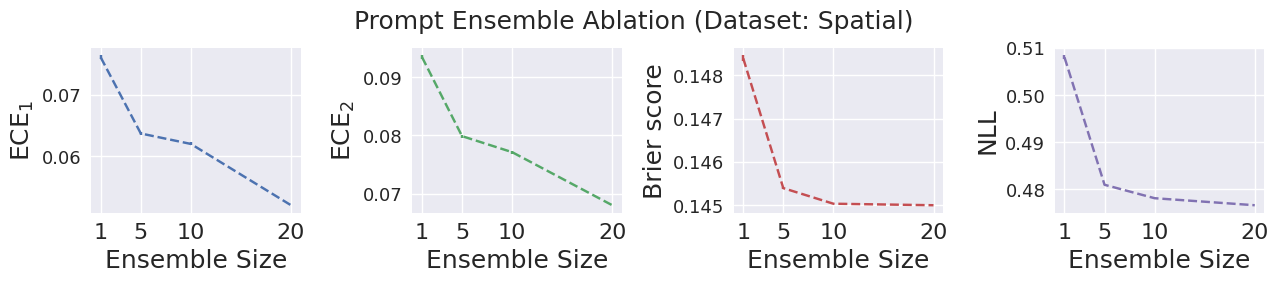

,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
4,goal,reprompt,1,0.123973,0.147375,0.201002,0.665808
5,goal,reprompt,5,0.117559,0.136877,0.197985,0.625660
6,goal,reprompt,10,0.116803,0.135139,0.197618,0.621559
7,goal,reprompt,20,0.115000,0.132000,0.197000,0.619534


,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
4,goal,reprompt,1,0.007527,0.010490,0.002510,0.013832
5,goal,reprompt,5,0.003598,0.006296,0.001047,0.004906
6,goal,reprompt,10,0.002864,0.005672,0.000626,0.002698
7,goal,reprompt,20,NaN,NaN,NaN,NaN


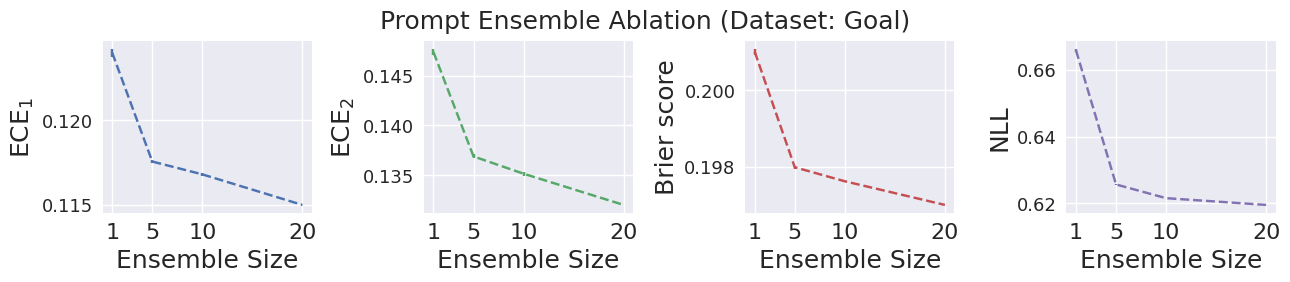

,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
12,object,reprompt,1,0.052702,0.063160,0.106924,0.382376
13,object,reprompt,5,0.043171,0.054933,0.104967,0.364098
14,object,reprompt,10,0.042148,0.055825,0.104797,0.362093
15,object,reprompt,20,0.036000,0.053000,0.105000,0.360989


,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
12,object,reprompt,1,0.006801,0.008031,0.001288,0.009179
13,object,reprompt,5,0.006537,0.008300,0.000592,0.003006
14,object,reprompt,10,0.005771,0.008130,0.000410,0.001698
15,object,reprompt,20,NaN,NaN,NaN,NaN


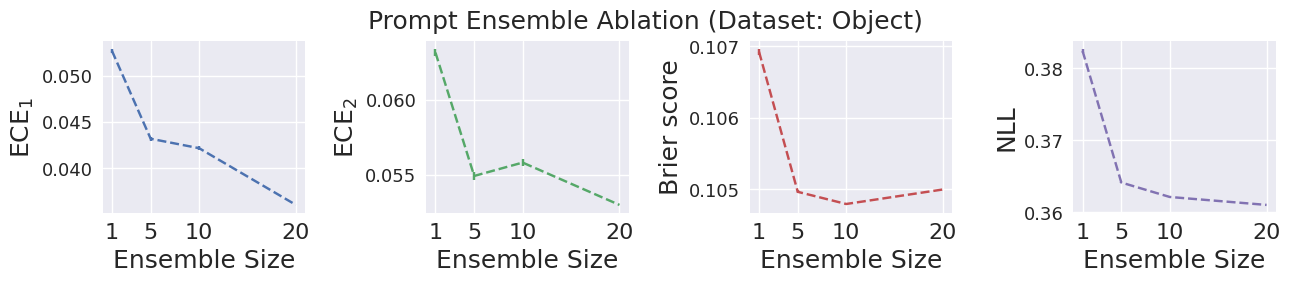

In [12]:
datasets = ["spatial", "goal", "object"]
for dataset in datasets:

    dataset_df = df[(df["Dataset"] == dataset) & (df["Method"] == "reprompt")]
    display(dataset_df)

    dataset_std_df = std_df[(std_df["Dataset"] == dataset) & (std_df["Method"] == "reprompt")]
    display(dataset_std_df)

    fig, axs = plt.subplots(1,4,figsize=(13, 3))

    axs[0].errorbar(n_prompt_list, dataset_df["ECE-1"].tolist(), fmt="--", yerr=np.array(dataset_std_df["ECE-1"].tolist())/np.sqrt(n_trials), color=pal[0])
    axs[1].errorbar(n_prompt_list, dataset_df["ECE-2"].tolist(), fmt="--", yerr=np.array(dataset_std_df["ECE-2"].tolist())/np.sqrt(n_trials), color=pal[1])
    axs[2].errorbar(n_prompt_list, dataset_df["Brier"].tolist(), fmt="--", yerr=np.array(dataset_std_df["Brier"].tolist())/np.sqrt(n_trials), color=pal[2])
    axs[3].errorbar(n_prompt_list, dataset_df["NLL"].tolist(), fmt="--", yerr=np.array(dataset_std_df["NLL"].tolist())/np.sqrt(n_trials), color=pal[3])

    axs[0].set_ylabel(r"$\text{ECE}_1$", fontsize=18)
    axs[1].set_ylabel(r"$\text{ECE}_2$", fontsize=18)
    axs[2].set_ylabel("Brier score", fontsize=18)
    axs[3].set_ylabel("NLL", fontsize=18)

    for i in range(4):
        axs[i].set_xlabel("Ensemble Size", fontsize=18)
        axs[i].set_xticks(n_prompt_list, n_prompt_list, size=16)
        axs[i].tick_params(axis='y', labelsize=13)
    
    fig.suptitle(f"Prompt Ensemble Ablation (Dataset: {str.title(dataset)})", y=0.925, fontsize=18)
    fig.tight_layout()
    plt.savefig(f"../plots/n_prompts_ablation_{dataset}_with_errors.png", dpi=600, bbox_inches="tight")
    plt.show()


,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
20,spatial,reprompt,1,0.076073,0.093486,0.148392,0.508017
21,spatial,reprompt,5,0.063686,0.079886,0.145395,0.480949
22,spatial,reprompt,10,0.061983,0.077133,0.145035,0.478098
23,spatial,reprompt,20,0.052000,0.068000,0.145000,0.476606


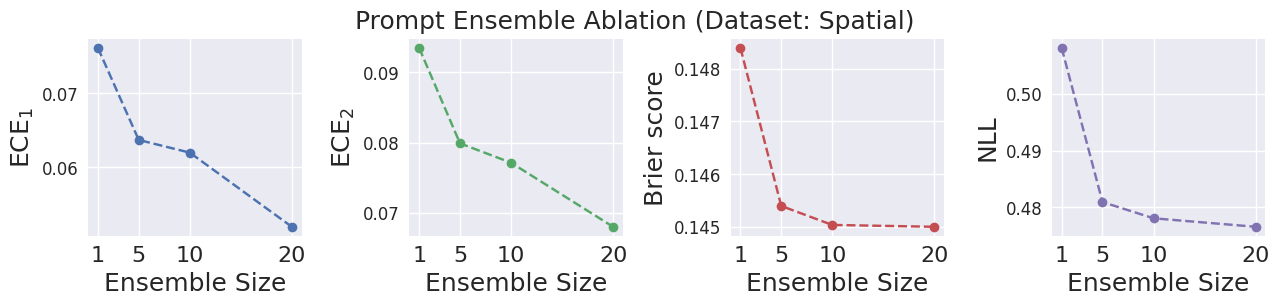

,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
4,goal,reprompt,1,0.123973,0.147375,0.201002,0.665808
5,goal,reprompt,5,0.117559,0.136877,0.197985,0.625660
6,goal,reprompt,10,0.116803,0.135139,0.197618,0.621559
7,goal,reprompt,20,0.115000,0.132000,0.197000,0.619534


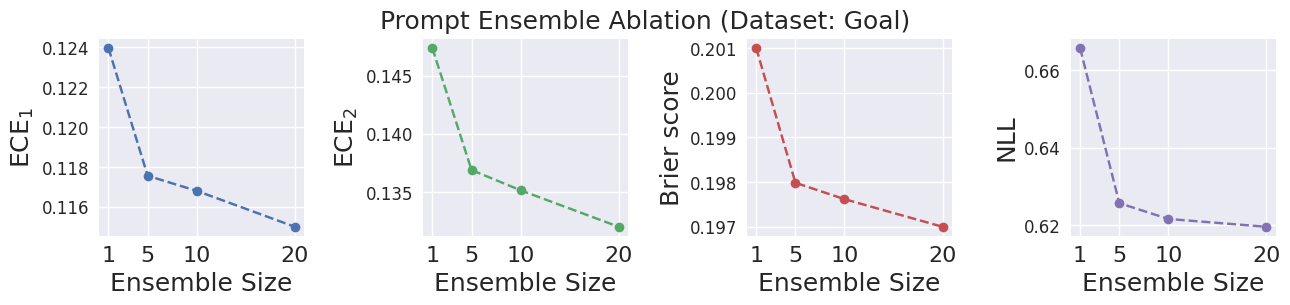

,Dataset,Method,n_prompts,ECE-1,ECE-2,Brier,NLL
12,object,reprompt,1,0.052702,0.063160,0.106924,0.382376
13,object,reprompt,5,0.043171,0.054933,0.104967,0.364098
14,object,reprompt,10,0.042148,0.055825,0.104797,0.362093
15,object,reprompt,20,0.036000,0.053000,0.105000,0.360989


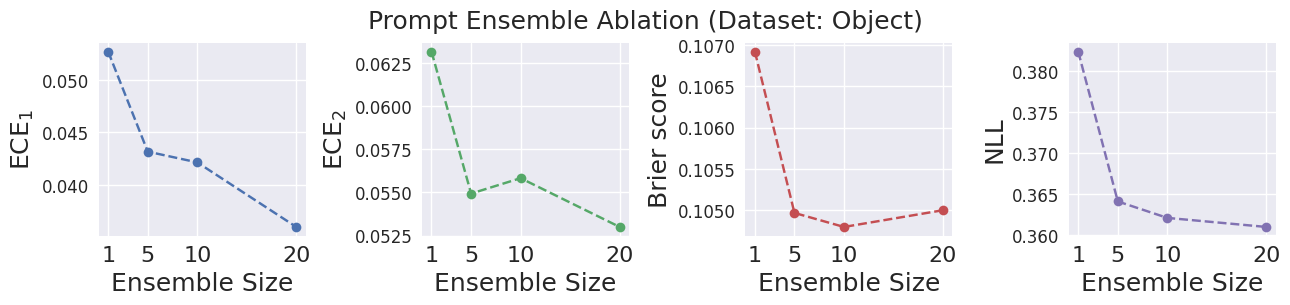

In [13]:
datasets = ["spatial", "goal", "object"]
for dataset in datasets:

    dataset_df = df[(df["Dataset"] == dataset) & (df["Method"] == "reprompt")]
    display(dataset_df)

    fig, axs = plt.subplots(1,4,figsize=(13, 3.25))

    axs[0].plot(n_prompt_list, dataset_df["ECE-1"].tolist(), "--o")
    axs[1].plot(n_prompt_list, dataset_df["ECE-2"].tolist(), "--o", color=pal[1])
    axs[2].plot(n_prompt_list, dataset_df["Brier"].tolist(), "--o", color=pal[2])
    axs[3].plot(n_prompt_list, dataset_df["NLL"].tolist(), "--o", color=pal[3])

    axs[0].set_ylabel(r"$\text{ECE}_1$", fontsize=18)
    axs[1].set_ylabel(r"$\text{ECE}_2$", fontsize=18)
    axs[2].set_ylabel("Brier score", fontsize=18)
    axs[3].set_ylabel("NLL", fontsize=18)

    for i in range(4):
        axs[i].set_xlabel("Ensemble Size", fontsize=18)
        axs[i].set_xticks(n_prompt_list, n_prompt_list, size=16)
        axs[i].tick_params(axis='y', labelsize=12)
    
    fig.suptitle(f"Prompt Ensemble Ablation (Dataset: {str.title(dataset)})", y=0.925, fontsize=18)
    fig.tight_layout()
    plt.savefig(f"../plots/n_prompts_ablation_{dataset}.png", dpi=600, bbox_inches="tight")
    plt.show()